# Task 1

1.a)  Simulate the trajectory of a ball with the parameters launch position (especially the height
above an imaginary ground), launch speed and launch angle of the ball

In [19]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

### Define here all the launch variables

In [20]:
# Define the launch variables
x0 = 0
y0_height = 10.0  # height from the ground in meters
v0_speed = 40.0  # speed of the ball in m/s
theta_0_angle = 45.0  # launch angle in degrees

# gravity in m/s^2 
g = 9.81  

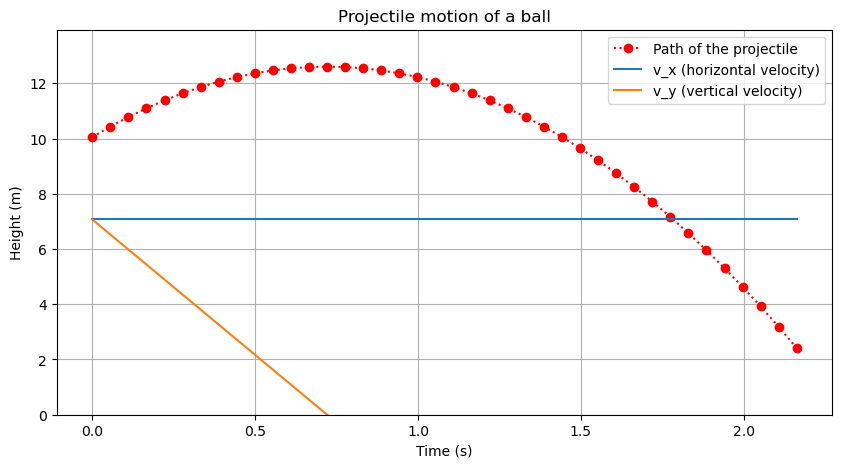

In [21]:
theta_0_angle = 45.0  # launch angle in degrees
v0_speed = 10.0  # speed of the ball in m/s
y0_height = 10.0  # height from the ground in meters
# Convert the launch angle to radians
angle_rad = np.deg2rad(theta_0_angle)

# Calculate the total time of flight
time_flight = (3*v0_speed*np.sin(angle_rad))/g

# Calculate the horizontal distance (range)
range_ball = v0_speed*np.cos(angle_rad)*time_flight

# Sample 
num = 40

# Generate time points
delta_t = np.linspace(0, time_flight, num)  # generate time points

# Calculate the x and y coordinates
x_real = v0_speed*np.cos(angle_rad)*delta_t + np.random.normal(0,0.1)
y_real = y0_height + v0_speed*np.sin(angle_rad)*delta_t - 0.5*g*delta_t**2 + np.random.normal(0,0.1)

# Calculate the x and y components of velocity
v_x = v0_speed*np.cos(angle_rad)  # constant
v_y = v0_speed*np.sin(angle_rad) - g*delta_t

# Calculate the velocity
velocity = np.sqrt(v_x**2 + v_y**2)  # magnitude of velocity

# Plot the trajectory
plt.figure(figsize=(10,5))
plt.plot(delta_t, y_real,'o:r', label='Path of the projectile')

plt.plot(delta_t, v_x*np.ones_like(delta_t), label='v_x (horizontal velocity)')  # plot Vx
plt.plot(delta_t, v_y, label='v_y (vertical velocity)')  # plot Vyy

plt.title('Projectile motion of a ball')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.grid(True)
plt.ylim(bottom=0)
plt.legend()
plt.show()

1.b) 
- Simulate the observation of the ball position (x, y as shown in the slides).
- The estimatedball position shall be subject to uncertainty and it shall be possible to parameterize this uncertainty. 
- In addition, the time span between two observations shall be variable and the observations shall be able to drop out completely over a certain period of time.
    - this cause reduction of the KF ability and rely more on the model predictions. 

In [22]:
# importing the important libraries 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

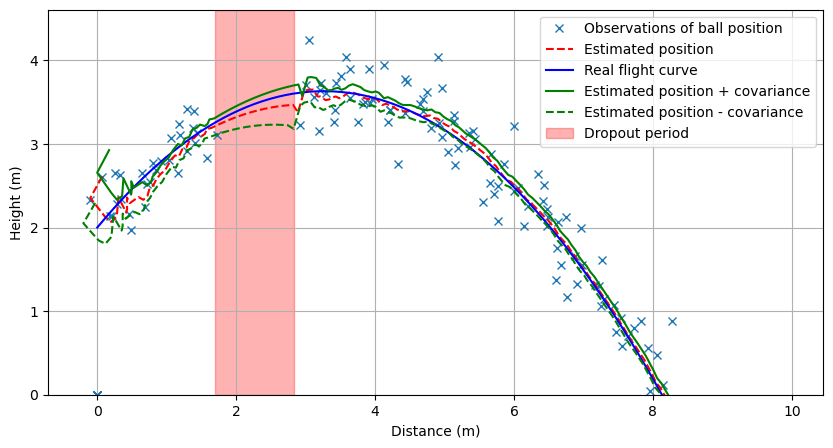

In [89]:
# importing the important libraries 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
# Define time step a
dt = 0.01
# initial speed
x0, y0, v0_speed, theta_0_angle = 0, 2, 8, 45
# gravity in m/s^2 
g = 9.81 

theta_0_angle = 45.0  # launch angle in degrees
angle_rad = np.deg2rad(theta_0_angle)
x_vel = v0_speed * np.cos(angle_rad)
y_vel = v0_speed * np.sin(angle_rad)

#Total time until it raches ground level y = 0
#total_time =  (v0 * np.sin(angle_rad) + np.sqrt((v0 * np.sin(angle_rad))**2 +g * y0)) /g 
total_time = (3*v0_speed*np.sin(angle_rad))/g

# Define initial state vector
# [x_pos, y_pos, x_vel, y_vel]
q_0= np.array([x0, y0, x_vel , y_vel])  

# Define initial covariance matrix( this same as np.array([[100.,0], [0., 100.]]))
# 
P_0 = np.eye(4) * 10000.

# Define transition matrix F
F= np.array([[1., 0, dt,  0],
              [0,  1., 0,  dt],
              [0,  0, 1., 0],
              [0,  0, 0,  1.]])

# Control input matrix
B = np.array([[0,   0,     0],
              [0,   0.5*dt, 0],
              [0,   0,      0],
              [0,   dt,    0]])

# Control vector
u = np.array([0, -g, 0])

# Define observation matrix (measurement matrix)
H = np.array([[1., 0, 0, 0],
              [0, 1., 0, 0]])

# Define process noise covariance
# Larger Q = low trust to my model
# Smaller Q = high trust to my model
# Model Prediction noise 
Q = block_diag(Q_discrete_white_noise(dim=2, dt=dt, var=0.01),
               Q_discrete_white_noise(dim=2, dt=dt, var=0.01))

# Define measurement noise covariance
# Larger R = low trust to my measuremnts
R = np.array([[0.01, 0],
              [0, 0.1]])



# Initialize the Kalman Filter
kf = KalmanFilter(dim_x=4, dim_z=2)
kf.x = q_0
kf.B = B
kf.F = F
kf.H = H
kf.Q = Q
kf.R = R
kf.P = P_0
#print(f"x: {x}, \nA_t:{A_t},\n C_t:{C_t},\n Q:{Q},\n R:{R},\n PO: {P0}")

# Generate noisy observations
t = np.arange(0, total_time, dt)
n = len(t)

z = np.zeros((n, 2))  # observed position
# Define the start and end time of the dropout 
t_drop_start = 0.3
t_drop_end = 0.5
for i in range(n):
     #Check if the current time is within the dropout period 
    if t_drop_start <= t[i] <= t_drop_end:
        continue
    # all the x axes observations
    z[i, 0] = q_0[0] + q_0[2]*t[i] + np.random.normal(0, np.sqrt(R[0, 0]))
    # all the y axes observations
    # y = y_0 + v_y * delta_t - 0.5 * g * delta_t ^2 
    z[i, 1] = q_0[1] + q_0[3]*t[i] - 0.5*g*t[i]**2 + np.random.normal(0, np.sqrt(R[1, 1]))

   
# Real Curve
p = np.zeros((n,2))
for i in range(n):
    # all the x axes observations
    p[i, 0] = q_0[0] + q_0[2]*t[i] 
    # all the y axes observations
    p[i, 1] = q_0[1] + q_0[3]*t[i] - 0.5*g*t[i]**2 

P_est = np.zeros((n, 4, 4))
# Use Kalman Filter for estimation
x_est = np.zeros((n, 4))  # estimated state
for i in range(n):
    kf.predict(B=B, u=u)
    if (t_drop_start <= t[i] <= t_drop_end):
        # Increase measurement noise during dropout period
        kf.R = np.array([[1000., 0],
              [0, 1000.]])
    else:
        kf.R = R
        kf.update(z[i])
    x_est[i] = kf.x
    P_est[i] = kf.P
    
# [x_pos, y_pos, x_vel, y_vel]

# Plot true and estimated position
plt.figure(figsize=(10,5))
plt.plot(z[:, 0], z[:, 1], 'x', label='Observations of ball position')


plt.plot(x_est[:, 0], x_est[:, 1], '--r', label='Estimated position')
plt.plot(p[:, 0], p[:, 1], 'b',label= "Real flight curve")
#plt.plot(x_real, y_real, label= "Real")

#plot the deviation ofcovariance of the estimated position
plt.plot(x_est[:, 0] + np.sqrt(P_est[:, 0, 0]), x_est[:, 1] + np.sqrt(P_est[:, 1, 1]), 'g', label='Estimated position + covariance')
plt.plot(x_est[:, 0] - np.sqrt(P_est[:, 0, 0]), x_est[:, 1] - np.sqrt(P_est[:, 1, 1]), 'g--', label='Estimated position - covariance')


plt.axvspan(t_drop_start * x_vel, t_drop_end * x_vel, color='red', alpha=0.3, label='Dropout period')

#plt.title('Estimated Position of the Ball Using Kalman Filter')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.ylim(bottom=0)
plt.legend(loc='best')
plt.grid(True)
plt.show()
